In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import os
from astropy import units as u
from tqdm import tqdm_notebook
from astropy.time import Time
from astropy.coordinates import SkyCoord, EarthLocation
from astropy.nddata import CCDData
import ccdproc as ccdp
from astropy.time import Time
from scipy.io import readsav
from math import log10
from scipy.interpolate import interp1d
from matplotlib.colors import LinearSegmentedColormap
from astropy.table import Table
from scipy.ndimage import percentile_filter

import starry
starry.config.lazy = False
starry.config.quiet = True

import warnings
warnings.filterwarnings("ignore")

plt.rcParams['font.size'] = 15
parula_colors = np.load('/Users/arcticfox/parula_colors.npy')
plot_dir = '/Users/arcticfox/Documents/atmospheres/v1298tau/figures/'
datadir = '/Users/arcticfox/Downloads/gemini_rereduced_twice'

#time = Time(np.load(os.path.join(datadir, 'mjddates.npy')), format='mjd')
#barycorr = np.load(os.path.join(datadir, 'barycorr.npy')) * u.km / u.s

from pylab import *
colormap='Greys'

cmap = cm.get_cmap(colormap, 60)
colors = []
for i in range(cmap.N):
    rgb = cmap(i)[:3]
    colors.append(matplotlib.colors.rgb2hex(rgb))
colors = np.array(colors[15:])

In [2]:
def hex_to_rgb(h):
    if '#' in h:
        h = h.lstrip('#')   
    hlen = int(len(h))
    rgb = tuple(int(h[i:int(i+hlen/3)], 16) / 255.0 for i in range(0, hlen, int(hlen/3)))
    return rgb

In [78]:
def grid_wavelength(wavelength, spectra, orders, factor):
    
    per = int(spectra.shape[1]*factor / len(np.unique(orders[0])))
    

    for i in range(len(wavelength)):
        print(i)
        tw, ts, to = np.array([]), np.array([]), np.array([])
        for o in np.unique(orders[0]):
            
            start = wavelength[i][orders[i]==o][0]
            end = wavelength[i][orders[i]==o][-1]

            redstart = np.nanmax(start)
            blueend  = np.nanmin(end)

            finer_wavelength = np.logspace(log10(redstart), log10(blueend),
                                           per, base=10.0)

            f = interp1d(wavelength[i][orders[i]==o], spectra[i][orders[i]==o])

            tw = np.append(tw, finer_wavelength[1:-1])
            ts = np.append(ts, f(finer_wavelength[1:-1]))
            to = np.append(to, np.full(len(finer_wavelength[1:-1]), o))
            
            
        if i == 0:
            interp_waves = np.zeros((wavelength.shape[0], len(tw)))
            interp_spect = np.zeros((spectra.shape[0], len(tw)))
            interp_ordrs = np.zeros((orders.shape[0],  len(tw)))
    
        interp_spect[i] = ts
        interp_waves[i] = tw
        interp_ordrs[i] = to

    return interp_waves, interp_spect, interp_ordrs

In [79]:
def extract_data(files):
    time = np.zeros(len(files))
    for i in range(len(files)):
        
        hdu = fits.open(files[i])

        if i == 0:
            wavelengths = np.zeros( (len(files), len(hdu[0].data[4])))
            spectra = np.zeros( (len(files), len(hdu[0].data[4])))
            orders = np.zeros( (len(files), len(hdu[0].data[4])))
        
        orders[i] = hdu[0].data[0]
        wavelengths[i] = hdu[0].data[4]
        spectra[i] = hdu[0].data[10]
        time[i] = hdu[0].header['MJDATE']
        
        hdu.close()
        
    return orders, wavelengths, spectra, time

In [80]:
FACTOR = 1
files = np.sort([os.path.join(datadir, i) for i in os.listdir(datadir) 
                 if i.endswith('m.fits')])
orders, wavelengths, spectra, TIME = extract_data(files)

In [81]:
interp_wavelengths, interp_spectra, interp_orders = grid_wavelength(wavelengths, 
                                                                     spectra, 
                                                                     orders,
                                                                     FACTOR)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42


(0.5, 1.3)

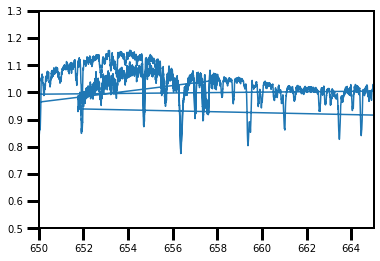

In [82]:
plt.plot(interp_wavelengths[0], interp_spectra[0])
plt.xlim(650,665)
plt.ylim(0.5,1.3)

In [83]:
def measure_excess(wavelength, spectra):
    global TIME
    
    widths = np.zeros(len(TIME))

    template_out = np.nanmedian(spectra, axis=0)

    for i in range(len(TIME)):

        ## CALCULATE EQUIVALENT WIDTH
        #line_area = np.abs(np.trapz(fl, x=wl))
        #continuum = np.nanmedian(fc)

        #frac = (fl[1:]-continuum)/continuum
        #dx = np.diff(wl)
        #summed_ew = np.nansum(frac * dx)

        ## CALCULATE EXCESS ABSORPTION
        widths[i] = np.nansum((spectra[i]/template_out) - 1) * -1

    return widths

In [84]:
lines = Table.read(os.path.join('/Users/arcticfox/Downloads/gemini_data/','fraunhofer.txt'), 
                   format='ascii')

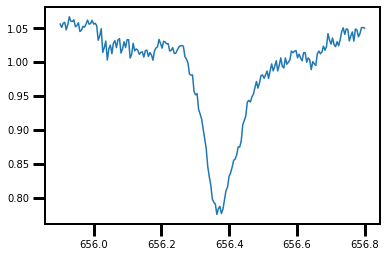

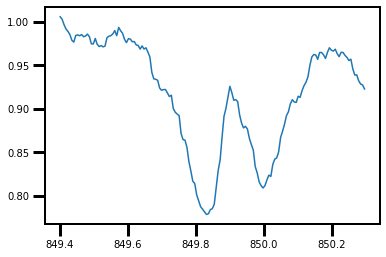

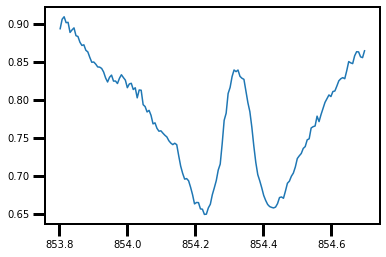

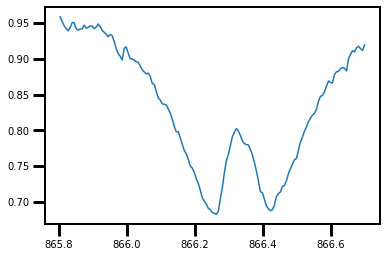

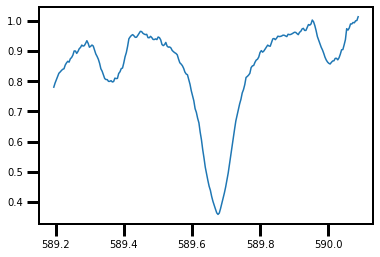

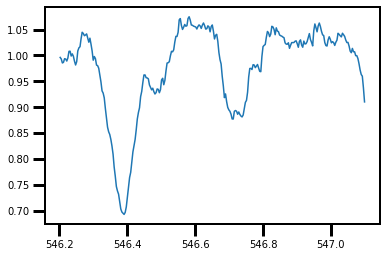

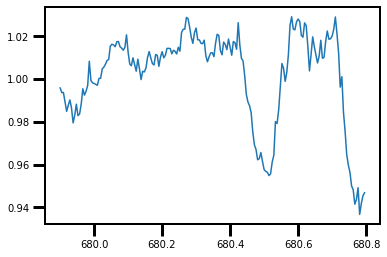

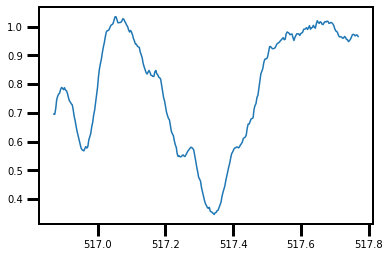

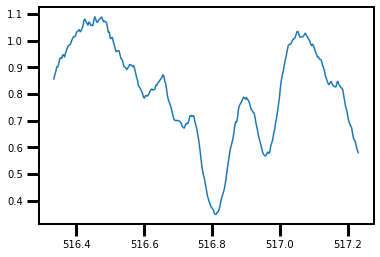

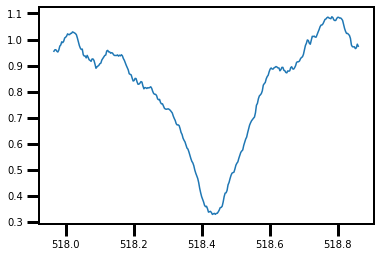

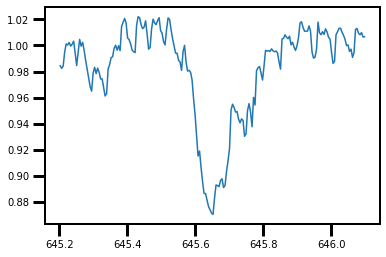

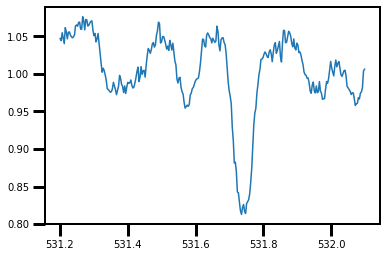

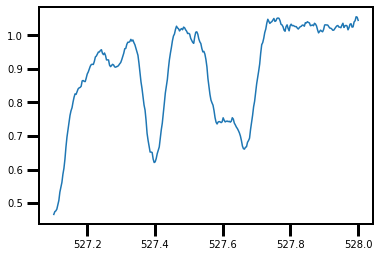

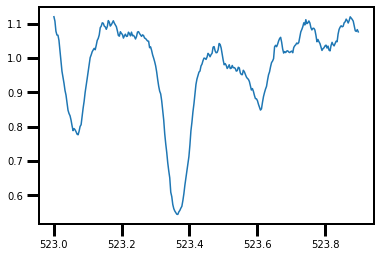

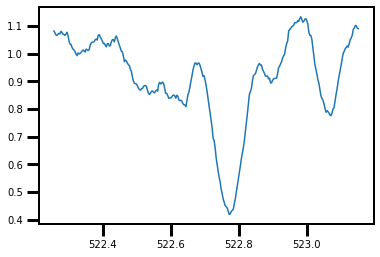

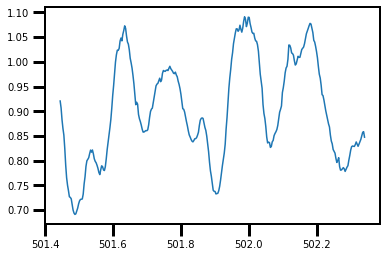

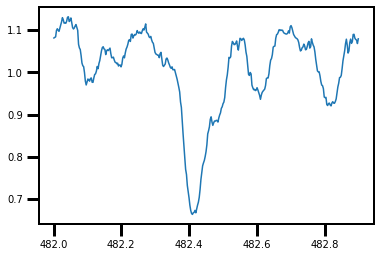

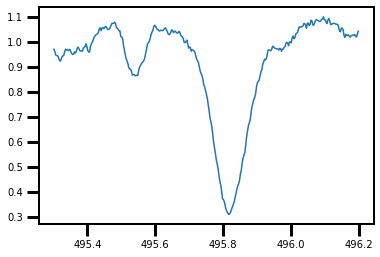

In [85]:
for x in range(len(lines)):
    o = lines['index'][x]
    if o < 23:
        o += 23
    q = np.where((interp_wavelengths[0] >= lines['rest_wavelength'][x]-0.4) & 
                  (interp_wavelengths[0] <= lines['rest_wavelength'][x]+0.5) &
                  (interp_orders[0] == o))[0]
    plt.plot(interp_wavelengths[0][q], interp_spectra[0][q])
    plt.show()

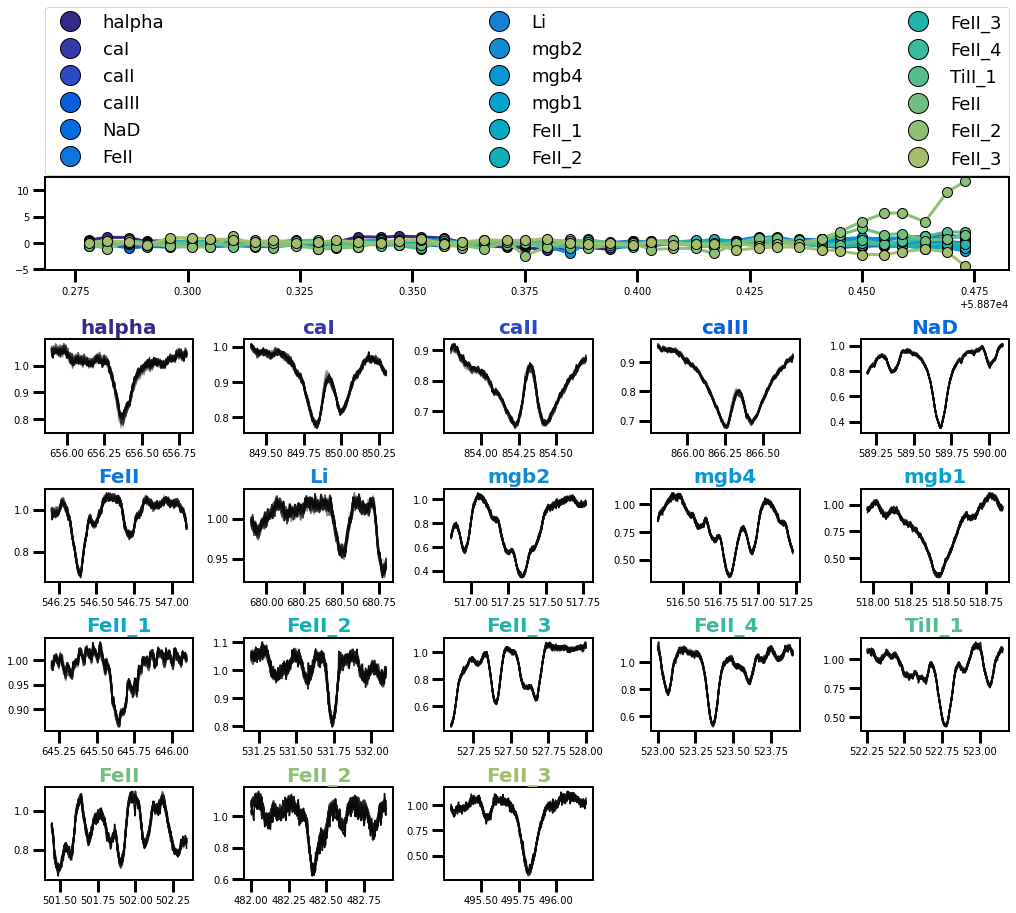

In [98]:
l = 3

line_offsets = [[0.25, 0.40], [0.25, 0.45], [0.50, 0.65],
                [0.40, 0.65], [0.17, 0.30], [0.40, 0.05],
                [0.03, 0.40], [0.23, 0.35], [0.32, 0.34]
               ]

fig = plt.figure(constrained_layout=True, figsize=(14,14))
gs  = fig.add_gridspec(6,5)
ax1 = fig.add_subplot(gs[0, :])


x, y = 1, 0

widths ={}
ind_waves = {}
ind_lines = {}

for ind in range(len(lines)):
    ordr = lines['index'][ind]
    if ordr < 23:
        ordr += 23
    q = np.where((interp_wavelengths[0] >= lines['rest_wavelength'][ind]-0.4) & 
                 (interp_wavelengths[0] <= lines['rest_wavelength'][ind]+0.5) &
                 (interp_orders[0] == ordr))
    
    w = measure_excess(interp_wavelengths[:,q], interp_spectra[:,q])
    widths[lines['line'][ind]] = w
    ind_waves[lines['line'][ind]] = np.reshape(interp_wavelengths[:,q], (len(files),
                                                                         len(interp_spectra[0][q])))
    ind_lines[lines['line'][ind]] = np.reshape(interp_spectra[:,q], (len(files),
                                                                     len(interp_spectra[0][q])))

    ax1.plot(TIME, w, c=parula_colors[ind*10], lw=3)
    ax1.plot(TIME, w, 'o', c=parula_colors[ind*10], ms=10, markeredgecolor='k',
             label=lines['line'][ind])

    ax = fig.add_subplot(gs[x,y])
    ax.set_title(lines['line'][ind], color=parula_colors[ind*10],
                 fontweight='bold', fontsize=20)
    for i in range(len(interp_wavelengths)):
        ax.plot(interp_wavelengths[i][q], interp_spectra[i][q], c=colors[i])
    

    y += 1
    if y == 5:
        x += 1
        y = 0
    
ax1.legend(bbox_to_anchor=(0., 1.02, 1., .12), loc='lower left',
           borderaxespad=0., ncol=3, fontsize=18, mode='expand')

In [99]:
clist = np.array(['#000000','#FFFFFF',
                  parula_colors[50],
                  ])
rgb_tuples = []

for c in clist:
    rgb_tuples.append(hex_to_rgb(c))

cm = LinearSegmentedColormap.from_list(
        'sequential', rgb_tuples, N=2048)

In [100]:
def expanding_bins(lines, repeat=3, subtract=True):
    global TIME
    
    med = np.nanmedian(lines, axis=0)
    binned = np.zeros( (len(TIME)*repeat, len(lines[0]))  )
            
    z = 0
    for i in range(len(lines)):
        if subtract == True:
            binned[z:z+repeat] = lines[i] - med
        else:
            binned[z:z+repeat] = lines[i]
        z += repeat
    return binned, med

In [101]:
def normalizing_depth(wave, spectra, plot=False):
    normalized = np.zeros(spectra.shape)
    
    if plot:
        fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(14,4))
    
    for i,flux in enumerate(spectra):

        norm_around_zero = flux - np.nanmedian(flux)
        area = np.trapz(norm_around_zero, wave[i])
        normalized[i] = norm_around_zero/np.abs(area)
        
        if plot:
            ax1.plot(wave[i], flux, c=parula_colors[i*4])
            ax2.plot(wave[i], norm_around_zero / np.abs(area),
                     c=parula_colors[i*4])
            
    if plot:
        plt.show()
    return normalized

In [102]:
halpha_normalized = normalizing_depth(ind_waves['halpha'], ind_lines['halpha'])

Text(0, 0.5, 'Normalized Spectra')

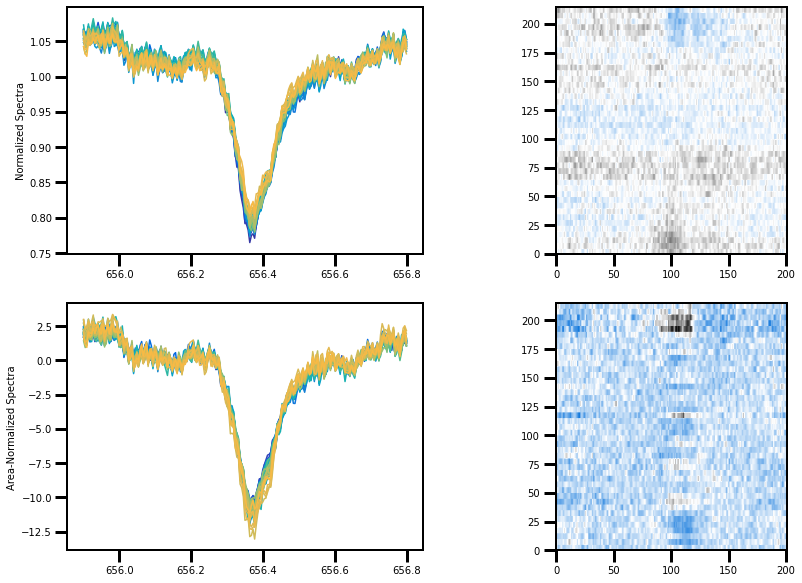

In [103]:
fig, ((ax3, ax1), (ax4, ax2)) = plt.subplots(ncols=2, nrows=2,
                                             figsize=(14,10))
for i in range(2,len(ind_lines['halpha'])):
    ax3.plot(ind_waves['halpha'][i], ind_lines['halpha'][i], c=parula_colors[i*5])
    ax4.plot(ind_waves['halpha'][i], halpha_normalized[i],   c=parula_colors[i*5])

bins, temp = expanding_bins(ind_lines['halpha'], repeat=5)
ax1.imshow(bins, cmap=cm, vmin=-0.05, vmax=0.05)

bins, temp = expanding_bins(halpha_normalized, repeat=5)
ax2.imshow(bins, cmap=cm)#, vmin=-1.25, vmax=1.25)

ax2.set_ylim(0,len(bins))
ax1.set_ylim(0,len(bins))
ax4.set_ylabel('Area-Normalized Spectra')
ax3.set_ylabel('Normalized Spectra')

#plt.savefig(os.path.join(plot_dir, 'halpha_compare.png'), dpi=200, rasterize=True,
#            bbox_inches='tight')

In [105]:
keys

['halpha',
 'caI',
 'caII',
 'caIII',
 'NaD',
 'FeII',
 'Li',
 'mgb2',
 'mgb4',
 'mgb1',
 'FeII_1',
 'FeII_2',
 'FeII_3',
 'FeII_4',
 'TiII_1']

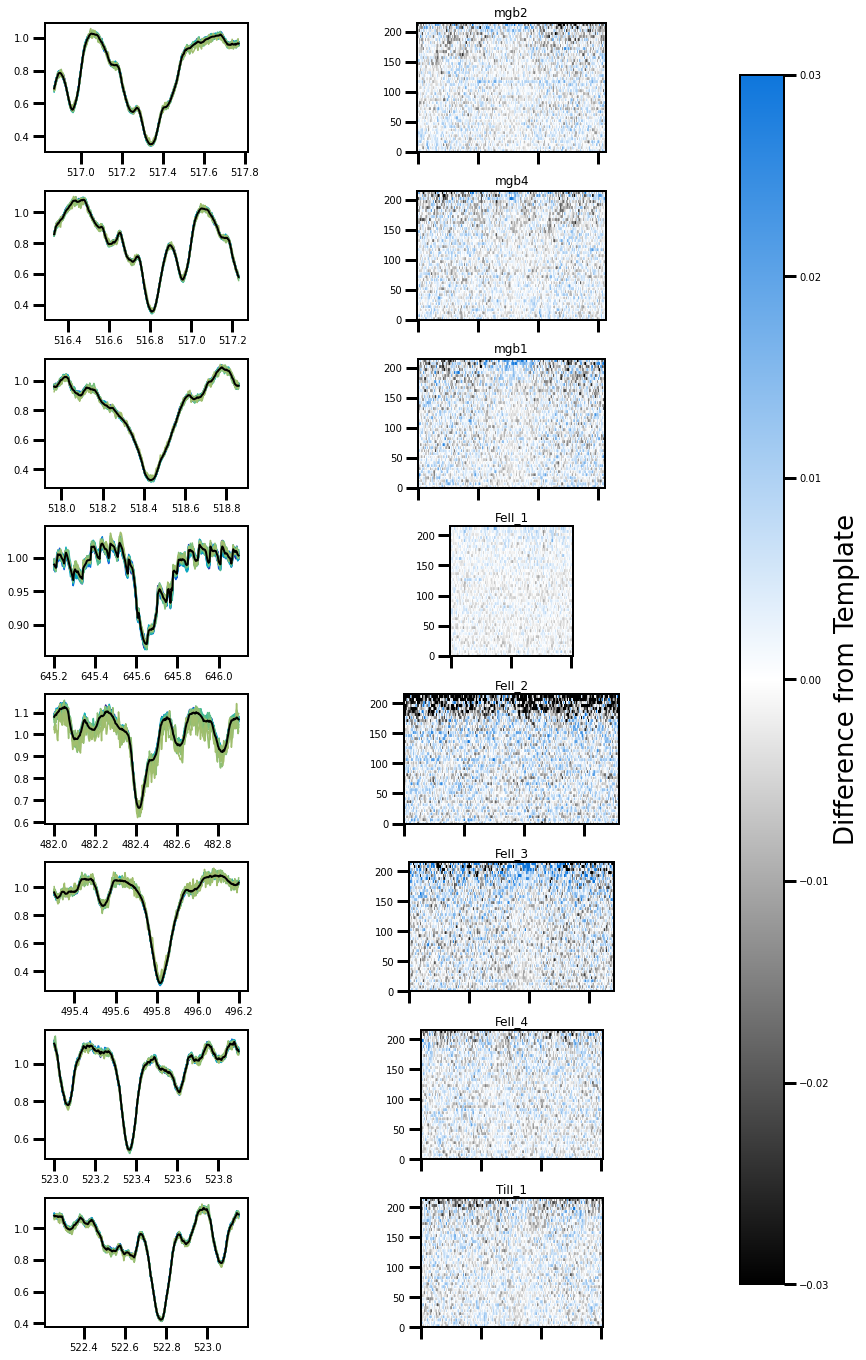

In [106]:
inds = np.arange(0,len(TIME)-6,4)

ratio=1.2
keys = list(ind_lines.keys())[7:]


fig, axes = plt.subplots(figsize=(12,24),
                         nrows=len(keys),
                         ncols=2,
                         gridspec_kw={'width_ratios':[1,2]})


i, x = 0, 0
for ax in axes.reshape(-1):

    bins, temp = expanding_bins(ind_lines[keys[x]],repeat=5)
    

    if i % 2 != 0:
        ax.set_title(keys[x])
        #bins = expanding_bins(lines[x], repeat=4)
        im = ax.imshow(bins, cmap=cm,
                       vmin=-0.03, vmax=0.03)
        ax.set_xticklabels([])
        ax.set_ylim(0,len(bins))
        x += 1
        
    else:
        for j in range(len(ind_waves[keys[x]])):
            #mask = ind_lines[keys[x]][j] < 1.0
            ax.plot(ind_waves[keys[x]][j],
                    ind_lines[keys[x]][j],
                    c=parula_colors[j*4])
        ax.plot(ind_waves[keys[x]][0], temp, 'k', lw=2)
        
    i += 1
    
cax = fig.add_axes([0.93, 0.15, 0.05, 0.7])
cbar = fig.colorbar(im, cax=cax)
cbar.set_label('Difference from Template', fontsize=26)
plt.subplots_adjust(hspace=0.3)
#plt.savefig(os.path.join('/Users/arcticfox/Documents/atmospheres/v1298tau/figures/',
#                         'deviations.png'), 
#            rasterize=True, bbox_inches='tight', dpi=200)